In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data you preprocessed
data = np.load('data/preprocessed/deconv_and_sta.npz', allow_pickle=True)

# These are the key arrays you'll use:
dff_inferred = data['dff_ds']      # The downsampled, cleaned calcium traces (cells x time)
t_inferred = data['t_ds']          # The corresponding time vector
fs_inferred = data['fs_ds'].item() # The sampling rate (~10 Hz)
dt = 1 / fs_inferred               # The time step between samples

print(f"Data loaded successfully!")
print(f"Shape of calcium traces: {dff_inferred.shape}")
print(f"Sampling rate: {fs_inferred:.2f} Hz")


Data loaded successfully!
Shape of calcium traces: (189, 22327)
Sampling rate: 10.05 Hz


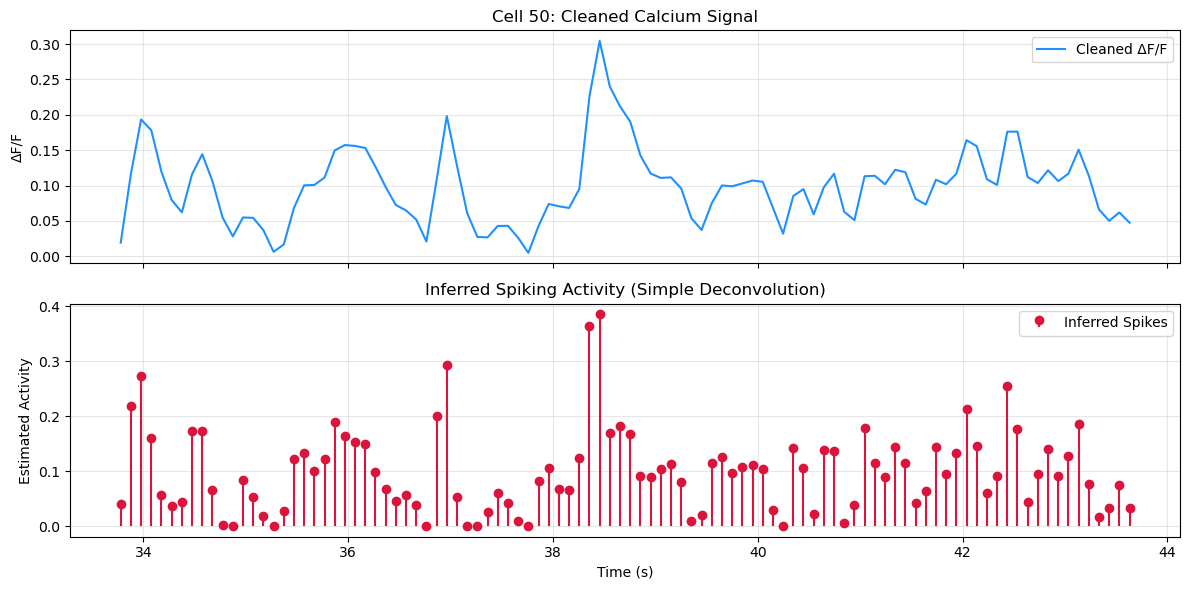

In [9]:


from scipy.signal import deconvolve as sp_deconvolve

def get_exponential_decay_kernel(tau: float, dt: float) -> np.ndarray:
    """Generates a normalized exponential decay kernel."""
    kernel_len = int(np.ceil(5 * tau / dt))
    t = np.arange(kernel_len) * dt
    kernel = np.exp(-t / tau)
    return kernel / kernel.sum()

def deconv_ca(ca: np.ndarray, tau: float, dt: float) -> np.ndarray:
    """Deconvolves a calcium trace using an exponential kernel."""
    kernel = get_exponential_decay_kernel(tau, dt)
    sp_hat, _ = sp_deconvolve(ca, kernel)
    sp_hat = np.pad(sp_hat, (0, ca.shape[0] - sp_hat.shape[0]), 'constant')
    sp_hat = np.clip(sp_hat, 0, None) # No negative spike rates!
    return sp_hat

# --- Parameters for your data ---
cell_to_analyze = 50                 # Pick a cell to analyze
tau_gcamp = 0.15                     # Decay constant for GCaMP6f (in seconds)

# --- Run the deconvolution ---
calcium_trace = dff_inferred[cell_to_analyze, :]
inferred_spikes = deconv_ca(calcium_trace, tau=tau_gcamp, dt=dt)


# only look at first 100 seconds for clarity
max_time = 10  # seconds
max_index = int(max_time / dt)
t_inferred = t_inferred[:max_index]
calcium_trace = calcium_trace[:max_index]
inferred_spikes = inferred_spikes[:max_index]


import matplotlib.pyplot as plt
import numpy as np

# (Assuming all your previous code, including data loading and deconvolution, is here)

# --- Plot the results ---
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# only look at first 100 seconds for clarity
max_time = 100  # seconds
max_index = int(max_time / dt)
t_inferred_segment = t_inferred[:max_index]
calcium_trace_segment = calcium_trace[:max_index]
inferred_spikes_segment = inferred_spikes[:max_index]

# Plot 1: Calcium Trace
ax[0].plot(t_inferred_segment, calcium_trace_segment, color='dodgerblue', label='Cleaned ΔF/F')
ax[0].set_title(f'Cell {cell_to_analyze}: Cleaned Calcium Signal')
ax[0].set_ylabel('ΔF/F')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot 2: Inferred Spikes using a Stem Plot
ax[1].stem(
    t_inferred_segment,
    inferred_spikes_segment,
    linefmt='crimson',    # Style for the vertical lines
    markerfmt='o',        # Remove markers at the top of the stem
    basefmt=" ",          # Remove the baseline
    label='Inferred Spikes'
)
ax[1].set_title('Inferred Spiking Activity (Simple Deconvolution)')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Estimated Activity')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()# Ensure the data is within the time limit


In [17]:
import numpy as np
from scipy.signal import deconvolve as sp_deconvolve
from tqdm import tqdm

In [23]:
# --- Load your preprocessed data ---
# This file should contain 'dff_ds', 't_ds', and 'fs_ds'
preprocessed_data = np.load('data/preprocessed/deconv_and_sta.npz', allow_pickle=True)
dff_clean = preprocessed_data['dff_ds']
t_vector = preprocessed_data['t_ds']
fs = preprocessed_data['fs_ds'].item()
dt = 1 / fs

# --- Process all cells ---
n_cells = dff_clean.shape[0]
inferred_spikes = np.zeros_like(dff_clean)
tau_gcamp = 0.15

print(f"Running deconvolution on {n_cells} cells...")
for i in tqdm(range(n_cells), desc="Inferring spikes"):
    inferred_spikes[i, :] = deconv_ca(dff_clean[i, :], tau=tau_gcamp, dt=dt)


Running deconvolution on 189 cells...


Inferring spikes: 100%|██████████| 189/189 [01:20<00:00,  2.33it/s]


In [30]:

# --- Persist the data to a file ---
from datetime import datetime
run_date_prefix_current_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
print(f"Saving inferred spikes data to file: {run_date_prefix_current_time}")
output_filename = f'./data/spike_inference/inferred_spikes_data_{run_date_prefix_current_time}.npz'

np.savez_compressed(
    output_filename,    
    inferred_spikes=inferred_spikes,
    sampling_frequency=fs,
    time_vector=t_vector,
    tau_gcamp=tau_gcamp,
    dff_clean=dff_clean # Good practice to save the source data too
)


Saving inferred spikes data to file: 2025_07_16_16_38_53
